In [95]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

df=pd.read_csv('big_corpus.csv')
df.head()


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"12 17, 2015",A2DABQ8D1XJT05,B00KWEH61U,Maryann,Love this 3ds game. I made a zombie Togepi wit...,Love this 3ds game,1450310400,NaN,NaN,NaN
1,5.0,True,"12 28, 2014",ANALWGWPY8HEA,B003S2JI82,John,Fun game,fun game,1419724800,NaN,{'Platform:': ' Nintendo Wii'},NaN
2,5.0,True,"09 2, 2013",AZC9D5RVK7GR6,B00DTWES6I,Tye D. Reed,This game is so fun. I think it is the best S...,Wow sooooo awsome,1378080000,NaN,"{'Edition:': ' Deluxe', 'Platform:': ' PC Down...",NaN
3,5.0,False,"01 15, 2018",A9SIXGGYKDBD,B01GKF7T9S,Jaguar 10,I hated the first game but absolutely love thi...,Don't let Watchdogs 1 Deter You - this game is...,1515974400,NaN,"{'Edition:': ' Standard', 'Platform:': ' PlayS...",NaN
4,5.0,True,"04 9, 2015",A1WDH8O30ZC16S,B00B67ZTUW,Atomic Kitty,Love the Tales games. Glad I purchased this one.,"Great game, interactive for two players as well.",1428537600,NaN,{'Color:': ' Playstation 3'},NaN


In [96]:
df.isnull().sum()

,0
overall,0
verified,0
reviewTime,0
reviewerID,0
asin,0
reviewerName,50
reviewText,38
summary,24
unixReviewTime,0
vote,78382


In [97]:
df.dropna(subset=['reviewText'], inplace=True)
df.shape

(99962, 12)

In [98]:
# text cleaning
def clean_text(text):
    text=text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['cleaned_review'] = df['reviewText'].apply(clean_text)

In [99]:
# create sentiment labels
def map_sentiment(rating):
  if rating<=2:
    return 0 # negative
  elif rating==3:
    return 1 # neutral
  else:
    return 2 # positive

df['sentiment']=df['overall'].apply(map_sentiment)

In [100]:
reviews=df['cleaned_review'].values
labels=df['sentiment'].values
print('Data cleaning and labeling complete.')
print('Example review:', reviews[0])
print('Example label:', labels[0])

Data cleaning and labeling complete.
Example review: love this ds game i made a zombie togepi with it and i only just started the game i was hoping to improve my skills but i just get sidetracked with creativity haha
Example label: 2


In [101]:
# Tokenization
voc_size=10000
tokenizer=Tokenizer(num_words=voc_size, oov_token='<OOV>')
tokenizer.fit_on_texts(reviews)
# convert text to sequences of integers
sequences=tokenizer.texts_to_sequences(reviews)

In [102]:
# Padding
max_len = int(np.percentile([len(seq) for seq in sequences], 95))
padded_sequences=pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
print(f"Vocabulary size: {voc_size}")
print(f"Maximum sequence length: {max_len}")
print(f"Padded sequence shape: {padded_sequences.shape}")

Vocabulary size: 10000
Maximum sequence length: 512
Padded sequence shape: (99962, 512)


## Dealing with imbalanced dataset

In [121]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train, X_test, y_train, y_test=train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# SMOTE: Synthetic Minority Over-Sampling Technique

print("Before SMOTE:", Counter(y_train))
# Initialize SMOTE
# k_neighbors is a key parameter to tune. The default is 5.
smote = SMOTE(k_neighbors=1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train_resampled))

# coverts labels to categorical for the model
y_train=to_categorical(y_train_resampled)
y_test=to_categorical(y_test)


(79969, 512) (19993, 512) (79969,) (19993,)
Before SMOTE: Counter({np.int64(2): 63200, np.int64(0): 8897, np.int64(1): 7872})
After SMOTE: Counter({np.int64(2): 63200, np.int64(0): 63200, np.int64(1): 63200})


In [118]:
# Building the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 128
model= Sequential([
    Embedding(voc_size,output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [119]:
batch_size=128
early_stopping=EarlyStopping(monitor='val_loss',min_delta=0.001, patience=3, restore_best_weights=True)
print('Training the model....')

history=model.fit(
    X_train_resampled,y_train,
    epochs=20,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping]
)
print('Training Completed!')

Training the model....
Epoch 1/20
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 170s 139ms/step - accuracy: 0.6872 - loss: 0.7470 - val_accuracy: 0.0000e+00 - val_loss: 1.5689
Epoch 2/20
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 204s 141ms/step - accuracy: 0.7656 - loss: 0.5857 - val_accuracy: 0.0094 - val_loss: 1.3220
Epoch 3/20


KeyboardInterrupt: 

## Checking the overall accuracy

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

loss,accuracy=model.evaluate(X_test,y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.8503 - loss: 0.3943
Test Loss: 0.3945
Test Accuracy: 85.01%


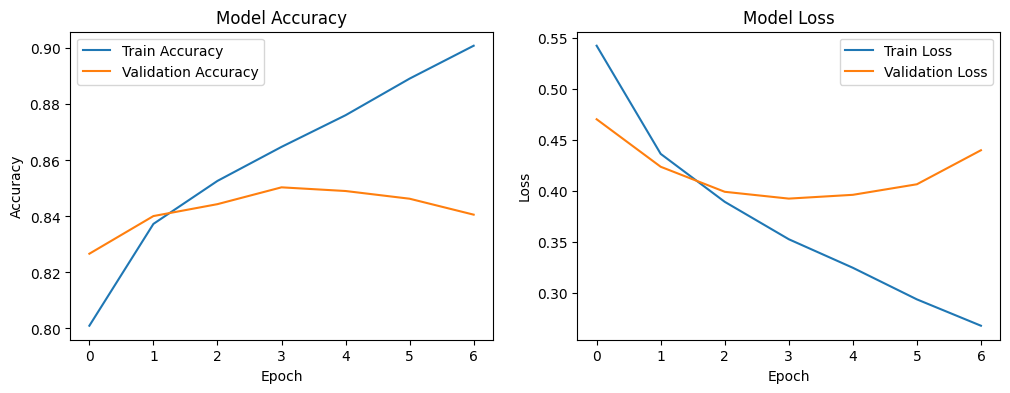

In [116]:
# plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.show()
plot_history(history)

Classification Report:
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step
              precision    recall  f1-score   support

    Negative       0.65      0.68      0.66      2206
     Neutral       0.35      0.08      0.13      1991
    Positive       0.89      0.97      0.93     15796

    accuracy                           0.85     19993
   macro avg       0.63      0.58      0.57     19993
weighted avg       0.81      0.85      0.82     19993

Confusion Matrix:
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step


<Axes: >

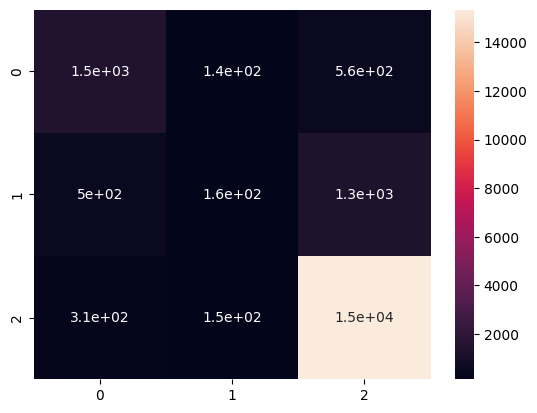

In [117]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), target_names=['Negative', 'Neutral','Positive']))

print("Confusion Matrix:")
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
sns.heatmap(cm, annot=True)